In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [19]:
# 1. Load Dataset
df = pd.read_csv("retail_customers_preprocessed.csv")
print("Dataset loaded, shape:", df.shape)


Dataset loaded, shape: (2233, 35)


In [20]:
# 2. Feature Selection
# Focusing on features that separate spending and purchase behavior
selected_features = [
    "annual_income",
    "spend_wine", "spend_fruits", "spend_meat", "spend_fish",
    "spend_sweets", "spend_gold",
    "num_web_purchases", "num_catalog_purchases", "num_store_purchases",
    "num_discount_purchases",
]

In [21]:
X = df[selected_features].copy()

In [22]:
# 3. Transform Skewed Features
# Most spend features are skewed; here we log-transform them
for col in ["spend_wine", "spend_fruits", "spend_meat", "spend_fish",
            "spend_sweets", "spend_gold"]:
    X[col] = np.log1p(X[col])  # log1p avoids log(0)

In [23]:
# 4. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [24]:
# 5. PCA (Keeping 90% variance)
pca = PCA(n_components=0.90, random_state=0)
X_pca = pca.fit_transform(X_scaled)
print("PCA components retained:", pca.n_components_)

PCA components retained: 7


In [25]:
# 6. KMeans Clustering (tuning k)
sil_scores = []
inertias = []
K_range = range(2, 13)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=0, n_init=20)
    labels = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    sil_scores.append(sil)
    inertias.append(km.inertia_)
    print(f"K={k}, Silhouette={sil:.4f}")

K=2, Silhouette=0.4245
K=3, Silhouette=0.3466
K=4, Silhouette=0.2650
K=5, Silhouette=0.2618
K=6, Silhouette=0.2657
K=7, Silhouette=0.2120
K=8, Silhouette=0.2067
K=9, Silhouette=0.1887
K=10, Silhouette=0.1966
K=11, Silhouette=0.1952
K=12, Silhouette=0.1797


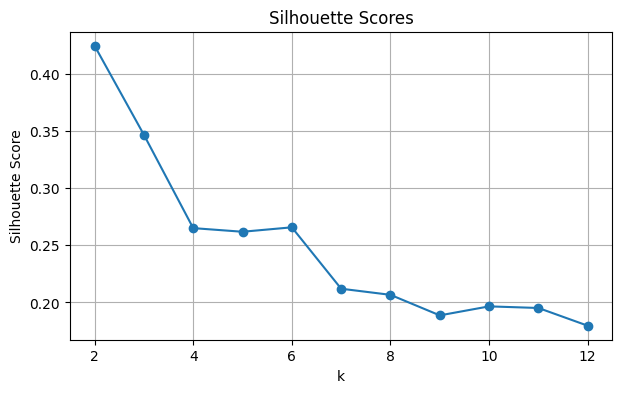

In [26]:
# 7. Plot Silhouette Scores
plt.figure(figsize=(7, 4))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores")
plt.grid(True)
plt.show()

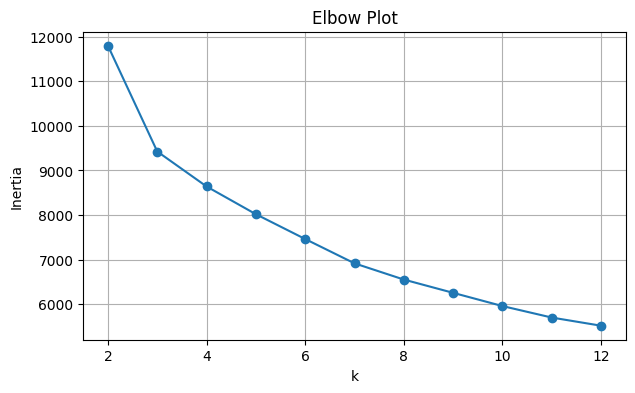

In [27]:
# 8. Elbow plot
plt.figure(figsize=(7, 4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Plot")
plt.grid(True)
plt.show()

In [28]:
# 9. Choose Best K Automatically

best_k = best_k = 3 #choosing the k value manually according to the elbow plot
print("Best k =", best_k)


Best k = 3


In [29]:
# 10. Fit Final KMeans

kmeans_final = KMeans(n_clusters=best_k, random_state=0, n_init=20)
df["cluster_kmeans"] = kmeans_final.fit_predict(X_pca)
final_sil = silhouette_score(X_pca, df["cluster_kmeans"])
print("Final Silhouette Score (KMeans):", final_sil)

Final Silhouette Score (KMeans): 0.34663868536477555


In [30]:
# 11. Cluster Summary
summary = df.groupby("cluster_kmeans")[selected_features].mean()
summary["count"] = df["cluster_kmeans"].value_counts()
print("\n=== Cluster Summary ===")
print(summary)


=== Cluster Summary ===
                annual_income  spend_wine  spend_fruits  spend_meat  \
cluster_kmeans                                                        
0                33950.588103   28.408530      3.736251   17.453423   
1                73078.313700  580.152369     61.921895  385.678617   
2                52179.210339  356.991087     12.303030   99.647059   

                spend_fish  spend_sweets  spend_gold  num_web_purchases  \
cluster_kmeans                                                            
0                 5.294052      3.885522   12.121212           1.778900   
1                88.427657     62.976953   73.706786           5.460948   
2                17.363636     13.973262   52.586453           5.832442   

                num_catalog_purchases  num_store_purchases  \
cluster_kmeans                                               
0                            0.397306             2.978676   
1                            5.445583             8.62099

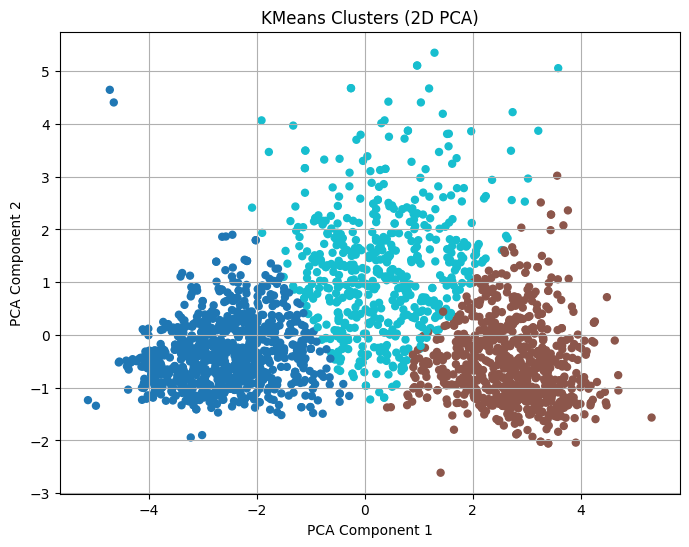

In [31]:
# 12. Visualization (2D PCA)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster_kmeans"], cmap="tab10", s=25)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("KMeans Clusters (2D PCA)")
plt.grid(True)
plt.show()